### Random Forests and Photo-zs

In this notebook, we use Random Forests to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y). It accompanies Chapter 6 of the book.

Essentially, we try to reproduce/improve upon the results of [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/).

Author: Viviana Acquaviva

License: TBD



In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [3]:
import astropy

from astropy.io import fits

#fits stands for Flexible Image Transport System; it's a format that allows one to store images and summary data

Data import

It's easiest IMO to read the data into a data frame using pandas:

In [4]:
with fits.open('/Users/vivi/Writing/MLBook/Chapter6/Notebooks/DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

In [5]:
df.columns

Index(['objno_deep2', 'ra_deep2', 'dec_deep2', 'magb', 'magr', 'magi', 'pgal',
       'sfd_ebv', 'class', 'subclass', 'objname', 'maskname', 'slitname',
       'date', 'mjd', 'z_raw', 'zhelio', 'z_err', 'rchi2', 'dof', 'vdisp',
       'vdisp_err', 'zquality', 'egsflags', 'comment', 'm_b', 'ub_0',
       'ra_cfhtls', 'dec_cfhtls', 'u', 'g', 'r', 'i', 'i2', 'z', 'uerr',
       'gerr', 'rerr', 'ierr', 'i2err', 'zerr', 'u_apercor', 'g_apercor',
       'r_apercor', 'i_apercor', 'i2_apercor', 'z_apercor', 'uerr_aper',
       'gerr_aper', 'rerr_aper', 'ierr_aper', 'i2err_aper', 'zerr_aper',
       'uerr_apercor', 'gerr_apercor', 'rerr_apercor', 'ierr_apercor',
       'i2err_apercor', 'zerr_apercor', 'r_radius_arcsec', 'u(sexflag)',
       'g(sexflag)', 'r(sexflag)', 'i(sexflag)', 'i2(sexflag)', 'z(sexflag)',
       'flag_cfhtls', 'cfhtls_source', 'ra_subaru', 'dec_subaru', 'y', 'yerr',
       'y_apercor', 'yerr_aper', 'yerr_apercor', 'y(sexflag)',
       'y_radius_arcsec', 'subaru_source'],
 

In [6]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,objname,maskname,slitname,date,mjd,z_raw,zhelio,z_err,rchi2,dof,vdisp,vdisp_err,zquality,egsflags,comment,m_b,ub_0,ra_cfhtls,dec_cfhtls,u,g,r,i,i2,z,uerr,gerr,rerr,ierr,i2err,zerr,u_apercor,g_apercor,r_apercor,i_apercor,i2_apercor,z_apercor,uerr_aper,gerr_aper,rerr_aper,ierr_aper,i2err_aper,zerr_aper,uerr_apercor,gerr_apercor,rerr_apercor,ierr_apercor,i2err_apercor,zerr_apercor,r_radius_arcsec,u(sexflag),g(sexflag),r(sexflag),i(sexflag),i2(sexflag),z(sexflag),flag_cfhtls,cfhtls_source,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',b'11001673',b'1101',b'000',b'2003-05-06',52765.457031,1.115297,1.115261,999.900024,0.630934,57.0,999.900024,999.900024,2,16777216,"b'bext, bcol, possible OII'",-999.000000,-999.0000,213.868620,51.956434,23.529039,23.393115,23.148170,22.854212,-99.0,22.162377,0.0678,0.0400,0.0382,0.0678,-99.0,0.0623,23.543491,23.430495,23.100311,22.768970,-99.0,22.223810,0.0542,0.0323,0.0279,0.0466,-99.0,0.0536,0.039631,0.041359,0.039777,0.046863,-99.0,0.043833,0.581804,3,3,3,3,-99,3,0,1,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',b'11001699',b'1100',b'7',b'2003-05-03',52762.441406,0.290641,0.290608,0.000043,1.178153,5901.0,166.334991,49.481255,4,16777216,b'',-19.228701,1.1295,213.810138,51.942348,30.123756,28.298480,18.540350,99.000000,-99.0,99.000000,0.0000,0.0000,0.0014,99.0000,-99.0,99.0000,30.848978,28.989668,19.027422,99.000000,-99.0,99.000000,0.0000,0.0000,0.0028,99.0000,-99.0,99.0000,0.029567,0.030353,0.027558,99.000000,-99.0,99.000000,0.824625,19,19,19,3,-99,3,244,1,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',b'11001770',b'1101',b'003',b'2003-05-06',52765.457031,0.605779,0.605744,-5.000000,1.047260,5318.0,184.860001,195.000000,1,16777216,b'',-999.000000,-999.0000,213.848409,51.948865,24.294289,24.399293,24.413366,23.398456,-99.0,24.157690,0.1646,0.1383,0.2306,0.1867,-99.0,0.4558,24.324670,24.273606,24.150319,23.446252,-99.0,23.574236,0.1146,0.0870,0.1242,0.1309,-99.0,0.1793,0.111127,0.130134,0.123620,0.117813,-99.0,0.101059,0.728119,0,0,0,0,-99,0,0,1,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',b'11001800',b'1100',b'004',b'2003-05-03',52762.441406,1.306830,1.306796,-5.000000,1.014062,5788.0,0.000000,0.000000,1,16777216,b'',-999.000000,-999.0000,213.831785,51.952539,26.363821,24.530998,23.559140,23.065110,-99.0,22.737333,0.9609,0.1344,0.0648,0.0997,-99.0,0.1110,99.000000,24.804309,23.636544,23.009222,-99.0,22.689591,99.0000,0.1077,0.0426,0.0568,-99.0,0.0661,99.000000,0.046521,0.041142,0.054297,-99.0,0.053818,0.549061,0,0,0,0,-99,0,0,1,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',b'11001860',b'1101',b'10',b'2003-05-06',52765.457031,0.957705,0.957669,0.000099,1.039979,5952.0,109.394997,17.208755,4,16777216,b'',-20.083200,0.7524,213.832540,51.954167,24.571406,24.023086,23.493832,22.691404,-99.0,22.387428,0.1924,0.0874,0.0651,0.0715,-99.0,0.0850,24.362068,24.136913,23.490342,22.777181,-99.0,22.319676,0.1002,0.0615,0.0420,0.0473,-99.0,0.0508,0.050326,0.053198,0.052364,0.058492,-99.0,0.053587,0.595684,0,0,0,0,-99,0,0,1,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [7]:
df.shape

(23822, 78)

I can select the columns I want, corresponding to the brightness of the galaxies in the six bands of interest.

In [8]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]

The target property is the redshift. For this catalog, spectroscopic (more precise) redshifts are available in the column below.

In [9]:
target = df['zhelio']

In [10]:
features.head(10)

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980
5,23.552186,23.420734,23.010863,22.550723,22.277656,21.860866
6,23.983330,24.104438,23.461145,23.359428,22.929944,22.690175
7,24.665840,24.408938,23.544115,23.155140,22.706477,22.894691
8,23.518039,22.746858,21.571629,20.645176,20.428926,20.306110
9,22.755723,21.915841,21.393365,21.148952,21.052236,20.830114


In [11]:
target.head(10)

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
5    0.909043
6    0.502974
7    0.649839
8    0.679440
9    0.074078
Name: zhelio, dtype: float32

### Ok, we are now ready to run our first Random Forest model!

To get an idea of what we are shooting for, we can look at the figure of the paper.

 ![Performance of photometric redshift reconstruction](Photoz_RF_CFHTLS_Deep.png)

In the figure above, $\sigma_{NMAD}$ is the normalized median absolute deviation of the residual vector, and $\eta$  is the fraction of outliers, defined as those objects for which (z_true - z_est)/(1+z_true) > 0.15.

To be fair, we are working with DEEP2/3 data, so our range is slightly different.

In [12]:
model = RandomForestRegressor()

In [13]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Establish benchmark.

In [14]:
scores = cross_validate(model,features,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [15]:
scores

{'fit_time': array([7.11974001, 7.09872532, 7.14143682, 7.1512363 , 7.09647107]),
 'score_time': array([0.09930682, 0.09299779, 0.09409785, 0.09450388, 0.09242892]),
 'test_score': array([0.30206109, 0.31039847, 0.31069834, 0.30699419, 0.31693559]),
 'train_score': array([0.87191611, 0.87837979, 0.87822485, 0.8779113 , 0.87547457])}

Note - it takes a litle time! Also, the scores are the R2 score at this point.

In [16]:
np.mean(scores['test_score'])

0.30941753572228814

In [17]:
np.mean(scores['train_score'])

0.8763813237518431

Looks like we have a severe high variance issue! Let's also check the predictions:

In [18]:
ypred = cross_val_predict(model,features,target, cv = KFold(n_splits=5, shuffle=True, random_state=10))

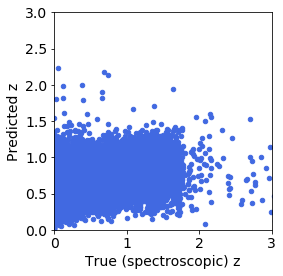

In [19]:
plt.scatter(target,ypred, s = 20, c = 'royalblue')
plt.xlabel('True (spectroscopic) z', fontsize=14)
plt.ylabel('Predicted z',fontsize=14)
plt.axis('square')
plt.xlim(0,3)
plt.ylim(0,3)
plt.savefig('Photoz_1_colors.pdf')

### Question: Does it look like the one of the paper?

It's also interesting to look at the distribution of the predicted values, to see how they always tend to produce a narrower distribution. Why?

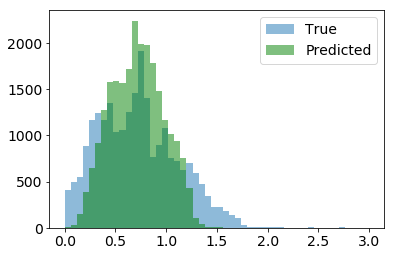

In [20]:
plt.hist(target,bins=50,density=False,alpha=0.5, range = (0,3), label = 'True');
plt.hist(ypred,bins=50,density=False,alpha=0.5, range = (0,3), color = 'g', label = 'Predicted');
plt.legend(fontsize=14);
plt.savefig('Dist_1_colors.pdf')

Ok, we are now ready to calculate the outlier fraction:

In [22]:
len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.25698933758710435

And NMAD

In [23]:
1.48*np.median(np.abs(target-ypred)/(1 + target)) 
#The 1.48 is there because for a Gaussian distribution, this becomes the standard deviation

0.074533209855643

### We have a pretty severe high variance issue, so we can perform some parameter optimization.

We can start by making the data set a bit smaller, as we have seen that timings were already challenging in simple k-fold CV.

In [24]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 5000, replace = False) #sample without replacement

In [25]:
len(np.unique(sel))

5000

And we create our new smaller data set.

In [26]:
seld = features.loc[sel,:]
selt = target[sel]

In [27]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [28]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

(0.2776271514859994, 0.8763722033397615)

Similar performance on training set ensures that size of data set is not a big issue and we can proceed with optimization.

#### Tree Parameters

The parameters associated to that are:

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required in a split node;

- The maximum depth of tree.

-  The criterion chosen to decide whether a split is "worth it", expressed in terms of information gain;


#### Randomization Parameters

- The number of k < n features that are used in building trees.

- The re-sampling (boostrap) of the data set (T or F).


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

In [29]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's discuss a possible set.

- min_impurity_decrease 

- number of trees

- max_leaf_nodes

- min_samples_split

- max_features





In [31]:
#Takes ~ 1 minute

parameters = {'min_impurity_decrease':[0.1, 0.5, 0.0], \
              'max_features':[None,4,2], 'n_estimators':[50, 100, 200], 'min_samples_split': [10,20,100], 
              'max_leaf_nodes':[None, 100, 200]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.2943 {'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 20, 'n_estimators': 200}


In [32]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [33]:
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
104,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.294289,0.018413,0.652302
185,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.293434,0.016198,0.621240
182,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.293174,0.018097,0.727079
103,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.292904,0.018149,0.651368
101,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.292827,0.015574,0.753346
...,...,...,...,...
81,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1, 'min_samples_split': 1...",-0.000103,0.000085,-0.000012
90,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.5, 'min_samples_split': 1...",-0.000104,0.000099,-0.000007
96,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.5, 'min_samples_split': 1...",-0.000106,0.000092,-0.000009
15,"{'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.5, 'min_samples_split'...",-0.000108,0.000093,-0.000015


In [34]:
#Takes ~ 1 minute

parameters = {'max_depth':[3, 6, None], \
              'max_features':[None,4,2], 'n_estimators':[50, 100, 200], 'min_samples_leaf': [5,10]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.3024 {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 5, 'n_estimators': 200}


In [35]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [36]:
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
44,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 5, 'n_estimators': 200}",0.302408,0.017800,0.626970
43,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 5, 'n_estimators': 100}",0.301089,0.015897,0.626109
38,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 200}",0.298195,0.015370,0.641591
40,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 100}",0.298044,0.018655,0.518954
41,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 200}",0.297389,0.019632,0.520105
47,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 10, 'n_estimators': 200}",0.297188,0.017834,0.506247
50,"{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 5, 'n_estimators': 200}",0.296929,0.020940,0.589990
39,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 50}",0.294355,0.020604,0.518421
46,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 10, 'n_estimators': 100}",0.294084,0.020543,0.505758
36,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 50}",0.293795,0.017997,0.636983


### And the verdict is....

We have NOT improved the test scores.




















### Time to look at data cleaning and/or imputing!

In my case, it was time to write to the authors of the paper, who told me exactly how they selected the data that went into making the learning set.

In [37]:
mags = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','subaru_source','cfhtls_source','zquality']]

In [38]:
mags.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,subaru_source,cfhtls_source,zquality
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356,1,1,2
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085,1,1,4
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000,-99,1,1
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600,1,1,1
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980,1,1,4


In [39]:
mags.shape

(23822, 9)

In [40]:
#redshift quality - only use objects with high-quality spectroscopic redshift measurements

mags = mags[mags['zquality'] >= 3]

mags.shape

(16857, 9)

In [41]:
#cfhtls deep photo 

mags = mags[mags['cfhtls_source'] == 0]

mags.shape

(10671, 9)

In [42]:
#Let's leave this out for now (subaru deep photo)

#mags = mags[mags['subaru_source'] == 0]

#mags.shape

Unavailable measurements are marked by -99 or 99 (while typical values are around 20-25). We can get rid of data with missing measurements.

In [43]:
mags = mags[mags > -10].dropna()

In [44]:
mags.shape

(6371, 9)

In [45]:
mags = mags[mags < 90].dropna()

In [46]:
mags.shape

(6307, 9)

Our final set is made of the six original features and it has 6,307 objects.

In [47]:
sel_features = mags[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]
sel_features.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
1251,24.244393,23.979583,23.522136,22.911041,22.525773,22.329098
1253,24.489104,23.916151,22.923651,21.873752,21.306495,21.251440
1261,24.873959,22.973893,21.465850,20.788420,20.462283,20.413696
1271,24.529042,24.338631,23.891189,23.206102,22.989344,23.112382
1272,23.641180,23.387447,22.975301,22.235199,21.809658,21.559483


We need, of course, to select the same set on the target vector.

In [48]:
sel_target = target[sel_features.index]

Let's see how our benchmark model works. Note that for reproducible results we need to fix the random\_state parameter of the Random Forest (which controls the bootstrap process) and the random seed of the cross validation. 

In [49]:
scores = cross_validate(RandomForestRegressor(random_state = 5),sel_features,sel_target,cv = KFold(n_splits=5, shuffle=True, random_state=10), \
               return_train_score=True)

In [50]:
print(np.round(np.mean(scores['test_score']),3), np.round(np.std(scores['test_score']),3))

0.746 0.106


In [51]:
print(np.round(np.mean(scores['train_score']),3), np.round(np.std(scores['train_score']),3))

0.963 0.005


The scores have improved noticeably! However, we can still observe high variance. We can re-run the optimization process (note that the data set size is limited, so we don't need to make it smaller).

In [52]:
#This now takes ~3 minutes

parameters = {'max_depth':[3, 6, None], \
              'max_features':[None,4,2], 'n_estimators':[50,100,200], 'min_samples_leaf': [1,5,10]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(random_state = 5), parameters, cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.7490 {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200}


In [53]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
65,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200}",0.748954,0.097339,0.964524
56,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.748619,0.105361,0.964307
55,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 100}",0.746483,0.105639,0.963281
64,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 100}",0.745839,0.096776,0.963471
63,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 50}",0.742806,0.095366,0.962624
59,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 200}",0.741669,0.105470,0.859758
73,"{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100}",0.741378,0.095392,0.962657
74,"{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 200}",0.740881,0.094959,0.963561
54,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}",0.740724,0.109204,0.962312
58,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 100}",0.740205,0.105767,0.859221


### Discussion Question: 

#### Do we need to explore some parameters more in detail (i.e., do we expect a significant improvement by enlarging the space of parameters?)

Probably not, because the scores are flat-ish over the first 10-20 models, suggesting that further optimization is unlikely to help significantly.

In [54]:
bm = model.best_estimator_

We can generate one set of predictions to visualize what happens.

In [55]:
ypred = cross_val_predict(bm, sel_features,sel_target, cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0, 3)

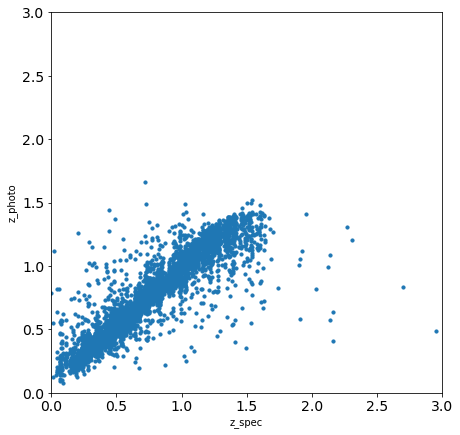

In [56]:
plt.figure(figsize=(7,7))
plt.scatter(sel_target,ypred, s =10)
plt.xlabel('z_spec')
plt.ylabel('z_photo')
plt.ylim(0,3)
plt.xlim(0,3)

Calculate outlier fraction and compare with the figure.

In [59]:
print(np.round(len(np.where(np.abs(sel_target.values.ravel()-ypred)>0.15*(1+sel_target.values.ravel()))[0])/len(sel_target.values.ravel()),3))

0.057


Calculate Normalized Median Absolute Deviation (NMAD).

In [60]:
print(np.round(1.48*np.median(np.abs(sel_target.values.ravel()-ypred)/(1 + sel_target.values.ravel())),3))

0.037


### Conclusion: How does our model compare with the paper's results?

We are doing slightly worse, but we have a secret weapon in feature engineering.

### Can you think of a feature engineering exercise that can be helpful?









Colors! We could instead use colors as features, to match what's done in the paper. The five colors u−g,g−r,r−i,i−z,z−y and i-band magnitude are used as the input.









